In [2]:
import os
import site
import sqlite3
import sys
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm
from yaml import dump, load, safe_load

In [3]:
log_path = "logs/"
log_file = "tseries1.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [4]:
sys.path.append("../../sql")
import queries

In [5]:
configs = None
try:
    with open("../source/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_locations"]["db_path"]
db_file = configs["file_locations"]["db_file"]
db_table1 = configs["file_locations"]["db_table1"]
db_table2 = configs["file_locations"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [6]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()
get_nsr_rows = queries.select_nsr_rows
year = "2020"
zipcode = "74145"

In [7]:
df = pd.read_sql(
    get_nsr_rows,
    conn,
    params={"zipcode": zipcode, "year": year},
    index_col="date_time",
    parse_dates=["date_time"],
)

In [8]:
df

,zipcode,DHI,DNI,GHI
date_time,,,,
2020-01-01 00:30:00,74145,0.0,0.0,0.0
2020-01-01 01:30:00,74145,0.0,0.0,0.0
2020-01-01 02:30:00,74145,0.0,0.0,0.0
2020-01-01 03:30:00,74145,0.0,0.0,0.0
2020-01-01 04:30:00,74145,0.0,0.0,0.0
...,...,...,...,...
2020-12-31 19:30:00,74145,0.0,0.0,0.0
2020-12-31 20:30:00,74145,0.0,0.0,0.0
2020-12-31 21:30:00,74145,0.0,0.0,0.0


In [9]:
df_daily = df.resample("D").sum()

In [10]:
df_daily

,DHI,DNI,GHI
date_time,,,
2020-01-01,631.0,6088.0,3028.0
2020-01-02,1209.0,1581.0,1913.0
2020-01-03,1009.0,3699.0,2391.0
2020-01-04,414.0,7743.0,3330.0
2020-01-05,477.0,7426.0,3306.0
...,...,...,...
2020-12-27,520.0,6946.0,3147.0
2020-12-28,1063.0,2316.0,1938.0
2020-12-29,568.0,402.0,646.0


In [11]:
decomp = seasonal_decompose(df_daily["DNI"], model="additive")

In [12]:
    plt.rcParams["figure.figsize"] = 30, 15
    plt.rcParams["ytick.labelsize"] = 11
    plt.rcParams["axes.labelsize"] = 14
    plt.rcParams["axes.labelpad"] = 12
    plt.rcParams["axes.xmargin"] = 0.01
    plt.rcParams["axes.ymargin"] = 0.01

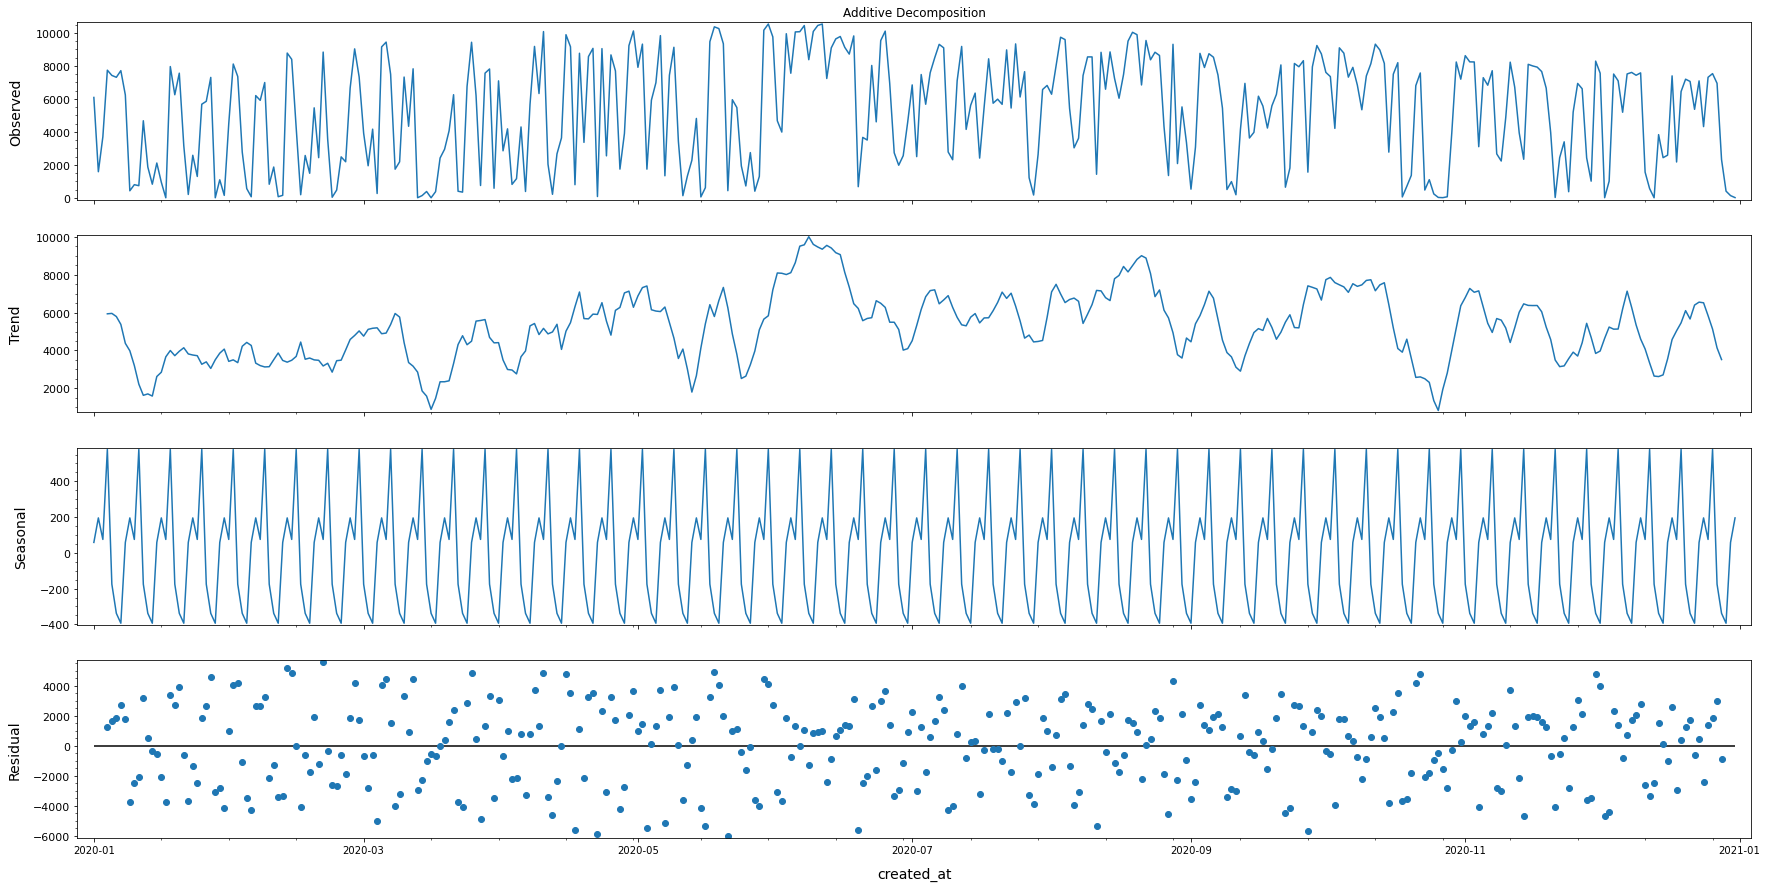

In [13]:
fig, ax = plt.subplots(4, sharex=True)
ax[0].set_title("Additive Decomposition")
ax[0].minorticks_on()
ax[0].plot(decomp.observed.index, decomp.observed)
ax[0].set(ylabel="Observed")

ax[1].plot(decomp.trend.index, decomp.trend)
ax[1].minorticks_on()
ax[1].set(ylabel="Trend")

ax[2].plot(decomp.seasonal.index, decomp.seasonal)
ax[2].minorticks_on()
ax[2].set(ylabel="Seasonal")

ax[3].plot(decomp.resid.index, decomp.resid, "o")
ax[3].hlines(0, xmin=min(decomp.resid.index), xmax=max(decomp.resid.index), colors="black")
ax[3].minorticks_on()
ax[3].set(xlabel="created_at", ylabel="Residual")

plt.show()